# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.1734
Epoch 1/200, Iteration 2/25, Loss: 0.1390
Epoch 1/200, Iteration 3/25, Loss: 0.1021
Epoch 1/200, Iteration 4/25, Loss: 0.0910
Epoch 1/200, Iteration 5/25, Loss: 0.0755
Epoch 1/200, Iteration 6/25, Loss: 0.0797
Epoch 1/200, Iteration 7/25, Loss: 0.0812
Epoch 1/200, Iteration 8/25, Loss: 0.0561
Epoch 1/200, Iteration 9/25, Loss: 0.0842
Epoch 1/200, Iteration 10/25, Loss: 0.0816
Epoch 1/200, Iteration 11/25, Loss: 0.0687
Epoch 1/200, Iteration 12/25, Loss: 0.0459
Epoch 1/200, Iteration 13/25, Loss: 0.0665
Epoch 1/200, Iteration 14/25, Loss: 0.0872
Epoch 1/200, Iteration 15/25, Loss: 0.0599
Epoch 1/200, Iteration 16/25, Loss: 0.0531
Epoch 1/200, Iteration 17/25, Loss: 0.0604
Epoch 1/200, Iteration 18/25, Loss: 0.0262
Epoch 1/200, Iteration 19/25, Loss: 0.0294
Epoch 1/200, Iteration 20/25, Loss: 0.0489
Epoch 1/200, Iteration 21/25, Loss: 0.0431
Epoch 1/200, Iteration 22/25, Loss: 0.0540
Epoch 1/200, Iteration 23/25, Loss: 0.0567
Epoch 1/200, Iterati

Train Error: 
 Accuracy: 97.25%, Avg loss: 0.023230, MRE: 1.160557 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.024857, MRE: 2.901725 

Epoch 8/200, Iteration 1/25, Loss: 0.0160
Epoch 8/200, Iteration 2/25, Loss: 0.0439
Epoch 8/200, Iteration 3/25, Loss: 0.0098
Epoch 8/200, Iteration 4/25, Loss: 0.0197
Epoch 8/200, Iteration 5/25, Loss: 0.0120
Epoch 8/200, Iteration 6/25, Loss: 0.0355
Epoch 8/200, Iteration 7/25, Loss: 0.0201
Epoch 8/200, Iteration 8/25, Loss: 0.0189
Epoch 8/200, Iteration 9/25, Loss: 0.0263
Epoch 8/200, Iteration 10/25, Loss: 0.0269
Epoch 8/200, Iteration 11/25, Loss: 0.0276
Epoch 8/200, Iteration 12/25, Loss: 0.0104
Epoch 8/200, Iteration 13/25, Loss: 0.0179
Epoch 8/200, Iteration 14/25, Loss: 0.0102
Epoch 8/200, Iteration 15/25, Loss: 0.0130
Epoch 8/200, Iteration 16/25, Loss: 0.0200
Epoch 8/200, Iteration 17/25, Loss: 0.0235
Epoch 8/200, Iteration 18/25, Loss: 0.0257
Epoch 8/200, Iteration 19/25, Loss: 0.0134
Epoch 8/200, Iteration 20/25, Loss: 0.0195
Epoch 8/200, 

Epoch 14/200, Iteration 21/25, Loss: 0.0223
Epoch 14/200, Iteration 22/25, Loss: 0.0151
Epoch 14/200, Iteration 23/25, Loss: 0.0106
Epoch 14/200, Iteration 24/25, Loss: 0.0172
Epoch 14/200, Iteration 25/25, Loss: 0.0310
Train Error: 
 Accuracy: 78.88%, Avg loss: 0.012004, MRE: 0.703633 

Test Error: 
 Accuracy: 81.5%, Avg loss: 0.012072, MRE: 2.200136 

Epoch 15/200, Iteration 1/25, Loss: 0.0123
Epoch 15/200, Iteration 2/25, Loss: 0.0329
Epoch 15/200, Iteration 3/25, Loss: 0.0182
Epoch 15/200, Iteration 4/25, Loss: 0.0208
Epoch 15/200, Iteration 5/25, Loss: 0.0312
Epoch 15/200, Iteration 6/25, Loss: 0.0139
Epoch 15/200, Iteration 7/25, Loss: 0.0420
Epoch 15/200, Iteration 8/25, Loss: 0.0167
Epoch 15/200, Iteration 9/25, Loss: 0.0194
Epoch 15/200, Iteration 10/25, Loss: 0.0206
Epoch 15/200, Iteration 11/25, Loss: 0.0172
Epoch 15/200, Iteration 12/25, Loss: 0.0201
Epoch 15/200, Iteration 13/25, Loss: 0.0195
Epoch 15/200, Iteration 14/25, Loss: 0.0177
Epoch 15/200, Iteration 15/25, Loss: 

Epoch 21/200, Iteration 22/25, Loss: 0.0241
Epoch 21/200, Iteration 23/25, Loss: 0.0143
Epoch 21/200, Iteration 24/25, Loss: 0.0282
Epoch 21/200, Iteration 25/25, Loss: 0.0201
Train Error: 
 Accuracy: 25.87%, Avg loss: 0.017707, MRE: 1.396327 

Test Error: 
 Accuracy: 27.0%, Avg loss: 0.016530, MRE: 1.845912 

Epoch 22/200, Iteration 1/25, Loss: 0.0401
Epoch 22/200, Iteration 2/25, Loss: 0.0352
Epoch 22/200, Iteration 3/25, Loss: 0.0434
Epoch 22/200, Iteration 4/25, Loss: 0.0245
Epoch 22/200, Iteration 5/25, Loss: 0.0227
Epoch 22/200, Iteration 6/25, Loss: 0.0217
Epoch 22/200, Iteration 7/25, Loss: 0.0226
Epoch 22/200, Iteration 8/25, Loss: 0.0116
Epoch 22/200, Iteration 9/25, Loss: 0.0176
Epoch 22/200, Iteration 10/25, Loss: 0.0199
Epoch 22/200, Iteration 11/25, Loss: 0.0204
Epoch 22/200, Iteration 12/25, Loss: 0.0427
Epoch 22/200, Iteration 13/25, Loss: 0.0315
Epoch 22/200, Iteration 14/25, Loss: 0.0149
Epoch 22/200, Iteration 15/25, Loss: 0.0176
Epoch 22/200, Iteration 16/25, Loss: 

Epoch 28/200, Iteration 18/25, Loss: 0.0367
Epoch 28/200, Iteration 19/25, Loss: 0.0219
Epoch 28/200, Iteration 20/25, Loss: 0.0089
Epoch 28/200, Iteration 21/25, Loss: 0.0153
Epoch 28/200, Iteration 22/25, Loss: 0.0333
Epoch 28/200, Iteration 23/25, Loss: 0.0174
Epoch 28/200, Iteration 24/25, Loss: 0.0153
Epoch 28/200, Iteration 25/25, Loss: 0.0141
Train Error: 
 Accuracy: 90.12%, Avg loss: 0.008258, MRE: 0.535708 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.009050, MRE: 1.713063 

Epoch 29/200, Iteration 1/25, Loss: 0.0067
Epoch 29/200, Iteration 2/25, Loss: 0.0106
Epoch 29/200, Iteration 3/25, Loss: 0.0277
Epoch 29/200, Iteration 4/25, Loss: 0.0214
Epoch 29/200, Iteration 5/25, Loss: 0.0308
Epoch 29/200, Iteration 6/25, Loss: 0.0249
Epoch 29/200, Iteration 7/25, Loss: 0.0138
Epoch 29/200, Iteration 8/25, Loss: 0.0182
Epoch 29/200, Iteration 9/25, Loss: 0.0365
Epoch 29/200, Iteration 10/25, Loss: 0.0199
Epoch 29/200, Iteration 11/25, Loss: 0.0139
Epoch 29/200, Iteration 12/25, Loss: 

Epoch 35/200, Iteration 21/25, Loss: 0.0238
Epoch 35/200, Iteration 22/25, Loss: 0.0131
Epoch 35/200, Iteration 23/25, Loss: 0.0105
Epoch 35/200, Iteration 24/25, Loss: 0.0214
Epoch 35/200, Iteration 25/25, Loss: 0.0193
Train Error: 
 Accuracy: 70.88%, Avg loss: 0.010199, MRE: 0.807974 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.010894, MRE: 1.531611 

Epoch 36/200, Iteration 1/25, Loss: 0.0170
Epoch 36/200, Iteration 2/25, Loss: 0.0113
Epoch 36/200, Iteration 3/25, Loss: 0.0136
Epoch 36/200, Iteration 4/25, Loss: 0.0132
Epoch 36/200, Iteration 5/25, Loss: 0.0309
Epoch 36/200, Iteration 6/25, Loss: 0.0142
Epoch 36/200, Iteration 7/25, Loss: 0.0108
Epoch 36/200, Iteration 8/25, Loss: 0.0239
Epoch 36/200, Iteration 9/25, Loss: 0.0155
Epoch 36/200, Iteration 10/25, Loss: 0.0344
Epoch 36/200, Iteration 11/25, Loss: 0.0293
Epoch 36/200, Iteration 12/25, Loss: 0.0113
Epoch 36/200, Iteration 13/25, Loss: 0.0304
Epoch 36/200, Iteration 14/25, Loss: 0.0326
Epoch 36/200, Iteration 15/25, Loss: 

Epoch 43/200, Iteration 8/25, Loss: 0.0103
Epoch 43/200, Iteration 9/25, Loss: 0.0254
Epoch 43/200, Iteration 10/25, Loss: 0.0148
Epoch 43/200, Iteration 11/25, Loss: 0.0073
Epoch 43/200, Iteration 12/25, Loss: 0.0108
Epoch 43/200, Iteration 13/25, Loss: 0.0302
Epoch 43/200, Iteration 14/25, Loss: 0.0334
Epoch 43/200, Iteration 15/25, Loss: 0.0171
Epoch 43/200, Iteration 16/25, Loss: 0.0256
Epoch 43/200, Iteration 17/25, Loss: 0.0166
Epoch 43/200, Iteration 18/25, Loss: 0.0154
Epoch 43/200, Iteration 19/25, Loss: 0.0176
Epoch 43/200, Iteration 20/25, Loss: 0.0252
Epoch 43/200, Iteration 21/25, Loss: 0.0108
Epoch 43/200, Iteration 22/25, Loss: 0.0107
Epoch 43/200, Iteration 23/25, Loss: 0.0192
Epoch 43/200, Iteration 24/25, Loss: 0.0205
Epoch 43/200, Iteration 25/25, Loss: 0.0230
Train Error: 
 Accuracy: 66.5%, Avg loss: 0.012065, MRE: 0.827899 

Test Error: 
 Accuracy: 71.5%, Avg loss: 0.012953, MRE: 1.249097 

Epoch 44/200, Iteration 1/25, Loss: 0.0163
Epoch 44/200, Iteration 2/25, Lo

Epoch 51/200, Iteration 9/25, Loss: 0.0112
Epoch 51/200, Iteration 10/25, Loss: 0.0174
Epoch 51/200, Iteration 11/25, Loss: 0.0204
Epoch 51/200, Iteration 12/25, Loss: 0.0269
Epoch 51/200, Iteration 13/25, Loss: 0.0156
Epoch 51/200, Iteration 14/25, Loss: 0.0141
Epoch 51/200, Iteration 15/25, Loss: 0.0152
Epoch 51/200, Iteration 16/25, Loss: 0.0164
Epoch 51/200, Iteration 17/25, Loss: 0.0139
Epoch 51/200, Iteration 18/25, Loss: 0.0210
Epoch 51/200, Iteration 19/25, Loss: 0.0128
Epoch 51/200, Iteration 20/25, Loss: 0.0443
Epoch 51/200, Iteration 21/25, Loss: 0.0251
Epoch 51/200, Iteration 22/25, Loss: 0.0143
Epoch 51/200, Iteration 23/25, Loss: 0.0202
Epoch 51/200, Iteration 24/25, Loss: 0.0088
Epoch 51/200, Iteration 25/25, Loss: 0.0105
Train Error: 
 Accuracy: 79.38%, Avg loss: 0.009721, MRE: 0.587968 

Test Error: 
 Accuracy: 78.5%, Avg loss: 0.009798, MRE: 1.495661 

Epoch 52/200, Iteration 1/25, Loss: 0.0222
Epoch 52/200, Iteration 2/25, Loss: 0.0124
Epoch 52/200, Iteration 3/25, L

Epoch 58/200, Iteration 9/25, Loss: 0.0130
Epoch 58/200, Iteration 10/25, Loss: 0.0145
Epoch 58/200, Iteration 11/25, Loss: 0.0145
Epoch 58/200, Iteration 12/25, Loss: 0.0149
Epoch 58/200, Iteration 13/25, Loss: 0.0072
Epoch 58/200, Iteration 14/25, Loss: 0.0217
Epoch 58/200, Iteration 15/25, Loss: 0.0155
Epoch 58/200, Iteration 16/25, Loss: 0.0139
Epoch 58/200, Iteration 17/25, Loss: 0.0078
Epoch 58/200, Iteration 18/25, Loss: 0.0139
Epoch 58/200, Iteration 19/25, Loss: 0.0140
Epoch 58/200, Iteration 20/25, Loss: 0.0082
Epoch 58/200, Iteration 21/25, Loss: 0.0529
Epoch 58/200, Iteration 22/25, Loss: 0.0107
Epoch 58/200, Iteration 23/25, Loss: 0.0196
Epoch 58/200, Iteration 24/25, Loss: 0.0208
Epoch 58/200, Iteration 25/25, Loss: 0.0130
Train Error: 
 Accuracy: 93.75%, Avg loss: 0.009090, MRE: 0.588179 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.009682, MRE: 2.098908 

Epoch 59/200, Iteration 1/25, Loss: 0.0140
Epoch 59/200, Iteration 2/25, Loss: 0.0089
Epoch 59/200, Iteration 3/25, L

Epoch 66/200, Iteration 2/25, Loss: 0.0186
Epoch 66/200, Iteration 3/25, Loss: 0.0329
Epoch 66/200, Iteration 4/25, Loss: 0.0179
Epoch 66/200, Iteration 5/25, Loss: 0.0378
Epoch 66/200, Iteration 6/25, Loss: 0.0324
Epoch 66/200, Iteration 7/25, Loss: 0.0198
Epoch 66/200, Iteration 8/25, Loss: 0.0102
Epoch 66/200, Iteration 9/25, Loss: 0.0130
Epoch 66/200, Iteration 10/25, Loss: 0.0119
Epoch 66/200, Iteration 11/25, Loss: 0.0294
Epoch 66/200, Iteration 12/25, Loss: 0.0249
Epoch 66/200, Iteration 13/25, Loss: 0.0250
Epoch 66/200, Iteration 14/25, Loss: 0.0349
Epoch 66/200, Iteration 15/25, Loss: 0.0368
Epoch 66/200, Iteration 16/25, Loss: 0.0162
Epoch 66/200, Iteration 17/25, Loss: 0.0087
Epoch 66/200, Iteration 18/25, Loss: 0.0245
Epoch 66/200, Iteration 19/25, Loss: 0.0112
Epoch 66/200, Iteration 20/25, Loss: 0.0160
Epoch 66/200, Iteration 21/25, Loss: 0.0301
Epoch 66/200, Iteration 22/25, Loss: 0.0326
Epoch 66/200, Iteration 23/25, Loss: 0.0084
Epoch 66/200, Iteration 24/25, Loss: 0.0

Epoch 72/200, Iteration 22/25, Loss: 0.0174
Epoch 72/200, Iteration 23/25, Loss: 0.0226
Epoch 72/200, Iteration 24/25, Loss: 0.0155
Epoch 72/200, Iteration 25/25, Loss: 0.0221
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.013069, MRE: 0.466359 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.015551, MRE: 1.073393 

Epoch 73/200, Iteration 1/25, Loss: 0.0207
Epoch 73/200, Iteration 2/25, Loss: 0.0492
Epoch 73/200, Iteration 3/25, Loss: 0.0215
Epoch 73/200, Iteration 4/25, Loss: 0.0190
Epoch 73/200, Iteration 5/25, Loss: 0.0178
Epoch 73/200, Iteration 6/25, Loss: 0.0142
Epoch 73/200, Iteration 7/25, Loss: 0.0115
Epoch 73/200, Iteration 8/25, Loss: 0.0082
Epoch 73/200, Iteration 9/25, Loss: 0.0211
Epoch 73/200, Iteration 10/25, Loss: 0.0132
Epoch 73/200, Iteration 11/25, Loss: 0.0373
Epoch 73/200, Iteration 12/25, Loss: 0.0111
Epoch 73/200, Iteration 13/25, Loss: 0.0323
Epoch 73/200, Iteration 14/25, Loss: 0.0160
Epoch 73/200, Iteration 15/25, Loss: 0.0095
Epoch 73/200, Iteration 16/25, Loss: 

Train Error: 
 Accuracy: 48.38%, Avg loss: 0.012472, MRE: 0.629328 

Test Error: 
 Accuracy: 47.5%, Avg loss: 0.012470, MRE: 1.246182 

Epoch 81/200, Iteration 1/25, Loss: 0.0271
Epoch 81/200, Iteration 2/25, Loss: 0.0244
Epoch 81/200, Iteration 3/25, Loss: 0.0185
Epoch 81/200, Iteration 4/25, Loss: 0.0108
Epoch 81/200, Iteration 5/25, Loss: 0.0294
Epoch 81/200, Iteration 6/25, Loss: 0.0157
Epoch 81/200, Iteration 7/25, Loss: 0.0170
Epoch 81/200, Iteration 8/25, Loss: 0.0085
Epoch 81/200, Iteration 9/25, Loss: 0.0170
Epoch 81/200, Iteration 10/25, Loss: 0.0172
Epoch 81/200, Iteration 11/25, Loss: 0.0347
Epoch 81/200, Iteration 12/25, Loss: 0.0342
Epoch 81/200, Iteration 13/25, Loss: 0.0113
Epoch 81/200, Iteration 14/25, Loss: 0.0225
Epoch 81/200, Iteration 15/25, Loss: 0.0171
Epoch 81/200, Iteration 16/25, Loss: 0.0136
Epoch 81/200, Iteration 17/25, Loss: 0.0152
Epoch 81/200, Iteration 18/25, Loss: 0.0367
Epoch 81/200, Iteration 19/25, Loss: 0.0140
Epoch 81/200, Iteration 20/25, Loss: 

Epoch 87/200, Iteration 19/25, Loss: 0.0125
Epoch 87/200, Iteration 20/25, Loss: 0.0113
Epoch 87/200, Iteration 21/25, Loss: 0.0280
Epoch 87/200, Iteration 22/25, Loss: 0.0139
Epoch 87/200, Iteration 23/25, Loss: 0.0199
Epoch 87/200, Iteration 24/25, Loss: 0.0289
Epoch 87/200, Iteration 25/25, Loss: 0.0251
Train Error: 
 Accuracy: 61.38%, Avg loss: 0.012272, MRE: 0.879118 

Test Error: 
 Accuracy: 64.5%, Avg loss: 0.011942, MRE: 1.684770 

Epoch 88/200, Iteration 1/25, Loss: 0.0137
Epoch 88/200, Iteration 2/25, Loss: 0.0080
Epoch 88/200, Iteration 3/25, Loss: 0.0192
Epoch 88/200, Iteration 4/25, Loss: 0.0190
Epoch 88/200, Iteration 5/25, Loss: 0.0140
Epoch 88/200, Iteration 6/25, Loss: 0.0164
Epoch 88/200, Iteration 7/25, Loss: 0.0132
Epoch 88/200, Iteration 8/25, Loss: 0.0096
Epoch 88/200, Iteration 9/25, Loss: 0.0330
Epoch 88/200, Iteration 10/25, Loss: 0.0073
Epoch 88/200, Iteration 11/25, Loss: 0.0155
Epoch 88/200, Iteration 12/25, Loss: 0.0138
Epoch 88/200, Iteration 13/25, Loss: 

Epoch 95/200, Iteration 14/25, Loss: 0.0175
Epoch 95/200, Iteration 15/25, Loss: 0.0230
Epoch 95/200, Iteration 16/25, Loss: 0.0358
Epoch 95/200, Iteration 17/25, Loss: 0.0135
Epoch 95/200, Iteration 18/25, Loss: 0.0196
Epoch 95/200, Iteration 19/25, Loss: 0.0117
Epoch 95/200, Iteration 20/25, Loss: 0.0099
Epoch 95/200, Iteration 21/25, Loss: 0.0076
Epoch 95/200, Iteration 22/25, Loss: 0.0117
Epoch 95/200, Iteration 23/25, Loss: 0.0139
Epoch 95/200, Iteration 24/25, Loss: 0.0124
Epoch 95/200, Iteration 25/25, Loss: 0.0413
Train Error: 
 Accuracy: 44.12%, Avg loss: 0.015345, MRE: 0.423704 

Test Error: 
 Accuracy: 41.5%, Avg loss: 0.016268, MRE: 1.027392 

Epoch 96/200, Iteration 1/25, Loss: 0.0133
Epoch 96/200, Iteration 2/25, Loss: 0.0126
Epoch 96/200, Iteration 3/25, Loss: 0.0083
Epoch 96/200, Iteration 4/25, Loss: 0.0339
Epoch 96/200, Iteration 5/25, Loss: 0.0249
Epoch 96/200, Iteration 6/25, Loss: 0.0279
Epoch 96/200, Iteration 7/25, Loss: 0.0135
Epoch 96/200, Iteration 8/25, Loss:

Epoch 102/200, Iteration 4/25, Loss: 0.0365
Epoch 102/200, Iteration 5/25, Loss: 0.0296
Epoch 102/200, Iteration 6/25, Loss: 0.0164
Epoch 102/200, Iteration 7/25, Loss: 0.0092
Epoch 102/200, Iteration 8/25, Loss: 0.0155
Epoch 102/200, Iteration 9/25, Loss: 0.0252
Epoch 102/200, Iteration 10/25, Loss: 0.0104
Epoch 102/200, Iteration 11/25, Loss: 0.0225
Epoch 102/200, Iteration 12/25, Loss: 0.0244
Epoch 102/200, Iteration 13/25, Loss: 0.0364
Epoch 102/200, Iteration 14/25, Loss: 0.0331
Epoch 102/200, Iteration 15/25, Loss: 0.0115
Epoch 102/200, Iteration 16/25, Loss: 0.0117
Epoch 102/200, Iteration 17/25, Loss: 0.0079
Epoch 102/200, Iteration 18/25, Loss: 0.0152
Epoch 102/200, Iteration 19/25, Loss: 0.0214
Epoch 102/200, Iteration 20/25, Loss: 0.0137
Epoch 102/200, Iteration 21/25, Loss: 0.0227
Epoch 102/200, Iteration 22/25, Loss: 0.0129
Epoch 102/200, Iteration 23/25, Loss: 0.0324
Epoch 102/200, Iteration 24/25, Loss: 0.0117
Epoch 102/200, Iteration 25/25, Loss: 0.0225
Train Error: 
 A

Train Error: 
 Accuracy: 86.5%, Avg loss: 0.007757, MRE: 0.525957 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.007461, MRE: 1.767573 

Epoch 110/200, Iteration 1/25, Loss: 0.0122
Epoch 110/200, Iteration 2/25, Loss: 0.0390
Epoch 110/200, Iteration 3/25, Loss: 0.0209
Epoch 110/200, Iteration 4/25, Loss: 0.0149
Epoch 110/200, Iteration 5/25, Loss: 0.0132
Epoch 110/200, Iteration 6/25, Loss: 0.0206
Epoch 110/200, Iteration 7/25, Loss: 0.0218
Epoch 110/200, Iteration 8/25, Loss: 0.0375
Epoch 110/200, Iteration 9/25, Loss: 0.0291
Epoch 110/200, Iteration 10/25, Loss: 0.0106
Epoch 110/200, Iteration 11/25, Loss: 0.0160
Epoch 110/200, Iteration 12/25, Loss: 0.0092
Epoch 110/200, Iteration 13/25, Loss: 0.0104
Epoch 110/200, Iteration 14/25, Loss: 0.0124
Epoch 110/200, Iteration 15/25, Loss: 0.0118
Epoch 110/200, Iteration 16/25, Loss: 0.0233
Epoch 110/200, Iteration 17/25, Loss: 0.0167
Epoch 110/200, Iteration 18/25, Loss: 0.0501
Epoch 110/200, Iteration 19/25, Loss: 0.0165
Epoch 110/200, Iter

Train Error: 
 Accuracy: 86.12%, Avg loss: 0.012596, MRE: 0.851368 

Test Error: 
 Accuracy: 84.5%, Avg loss: 0.012542, MRE: 3.211616 

Epoch 117/200, Iteration 1/25, Loss: 0.0199
Epoch 117/200, Iteration 2/25, Loss: 0.0197
Epoch 117/200, Iteration 3/25, Loss: 0.0238
Epoch 117/200, Iteration 4/25, Loss: 0.0150
Epoch 117/200, Iteration 5/25, Loss: 0.0063
Epoch 117/200, Iteration 6/25, Loss: 0.0224
Epoch 117/200, Iteration 7/25, Loss: 0.0157
Epoch 117/200, Iteration 8/25, Loss: 0.0126
Epoch 117/200, Iteration 9/25, Loss: 0.0231
Epoch 117/200, Iteration 10/25, Loss: 0.0282
Epoch 117/200, Iteration 11/25, Loss: 0.0239
Epoch 117/200, Iteration 12/25, Loss: 0.0162
Epoch 117/200, Iteration 13/25, Loss: 0.0215
Epoch 117/200, Iteration 14/25, Loss: 0.0172
Epoch 117/200, Iteration 15/25, Loss: 0.0136
Epoch 117/200, Iteration 16/25, Loss: 0.0153
Epoch 117/200, Iteration 17/25, Loss: 0.0238
Epoch 117/200, Iteration 18/25, Loss: 0.0144
Epoch 117/200, Iteration 19/25, Loss: 0.0149
Epoch 117/200, Ite

Epoch 124/200, Iteration 8/25, Loss: 0.0310
Epoch 124/200, Iteration 9/25, Loss: 0.0399
Epoch 124/200, Iteration 10/25, Loss: 0.0270
Epoch 124/200, Iteration 11/25, Loss: 0.0130
Epoch 124/200, Iteration 12/25, Loss: 0.0300
Epoch 124/200, Iteration 13/25, Loss: 0.0223
Epoch 124/200, Iteration 14/25, Loss: 0.0141
Epoch 124/200, Iteration 15/25, Loss: 0.0121
Epoch 124/200, Iteration 16/25, Loss: 0.0097
Epoch 124/200, Iteration 17/25, Loss: 0.0262
Epoch 124/200, Iteration 18/25, Loss: 0.0161
Epoch 124/200, Iteration 19/25, Loss: 0.0208
Epoch 124/200, Iteration 20/25, Loss: 0.0210
Epoch 124/200, Iteration 21/25, Loss: 0.0126
Epoch 124/200, Iteration 22/25, Loss: 0.0170
Epoch 124/200, Iteration 23/25, Loss: 0.0277
Epoch 124/200, Iteration 24/25, Loss: 0.0128
Epoch 124/200, Iteration 25/25, Loss: 0.0245
Train Error: 
 Accuracy: 42.5%, Avg loss: 0.011826, MRE: 0.796895 

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.010418, MRE: 1.353808 

Epoch 125/200, Iteration 1/25, Loss: 0.0383
Epoch 125/200

Train Error: 
 Accuracy: 80.88%, Avg loss: 0.006909, MRE: 0.431003 

Test Error: 
 Accuracy: 76.5%, Avg loss: 0.007361, MRE: 1.005165 

Epoch 132/200, Iteration 1/25, Loss: 0.0077
Epoch 132/200, Iteration 2/25, Loss: 0.0126
Epoch 132/200, Iteration 3/25, Loss: 0.0144
Epoch 132/200, Iteration 4/25, Loss: 0.0272
Epoch 132/200, Iteration 5/25, Loss: 0.0135
Epoch 132/200, Iteration 6/25, Loss: 0.0238
Epoch 132/200, Iteration 7/25, Loss: 0.0217
Epoch 132/200, Iteration 8/25, Loss: 0.0163
Epoch 132/200, Iteration 9/25, Loss: 0.0066
Epoch 132/200, Iteration 10/25, Loss: 0.0112
Epoch 132/200, Iteration 11/25, Loss: 0.0111
Epoch 132/200, Iteration 12/25, Loss: 0.0372
Epoch 132/200, Iteration 13/25, Loss: 0.0189
Epoch 132/200, Iteration 14/25, Loss: 0.0298
Epoch 132/200, Iteration 15/25, Loss: 0.0094
Epoch 132/200, Iteration 16/25, Loss: 0.0110
Epoch 132/200, Iteration 17/25, Loss: 0.0335
Epoch 132/200, Iteration 18/25, Loss: 0.0259
Epoch 132/200, Iteration 19/25, Loss: 0.0146
Epoch 132/200, Ite

Epoch 139/200, Iteration 11/25, Loss: 0.0115
Epoch 139/200, Iteration 12/25, Loss: 0.0204
Epoch 139/200, Iteration 13/25, Loss: 0.0227
Epoch 139/200, Iteration 14/25, Loss: 0.0066
Epoch 139/200, Iteration 15/25, Loss: 0.0225
Epoch 139/200, Iteration 16/25, Loss: 0.0103
Epoch 139/200, Iteration 17/25, Loss: 0.0286
Epoch 139/200, Iteration 18/25, Loss: 0.0155
Epoch 139/200, Iteration 19/25, Loss: 0.0333
Epoch 139/200, Iteration 20/25, Loss: 0.0156
Epoch 139/200, Iteration 21/25, Loss: 0.0191
Epoch 139/200, Iteration 22/25, Loss: 0.0111
Epoch 139/200, Iteration 23/25, Loss: 0.0136
Epoch 139/200, Iteration 24/25, Loss: 0.0156
Epoch 139/200, Iteration 25/25, Loss: 0.0219
Train Error: 
 Accuracy: 95.38%, Avg loss: 0.012032, MRE: 0.830851 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.012170, MRE: 2.506424 

Epoch 140/200, Iteration 1/25, Loss: 0.0137
Epoch 140/200, Iteration 2/25, Loss: 0.0320
Epoch 140/200, Iteration 3/25, Loss: 0.0188
Epoch 140/200, Iteration 4/25, Loss: 0.0126
Epoch 140/200

Epoch 147/200, Iteration 13/25, Loss: 0.0208
Epoch 147/200, Iteration 14/25, Loss: 0.0084
Epoch 147/200, Iteration 15/25, Loss: 0.0180
Epoch 147/200, Iteration 16/25, Loss: 0.0121
Epoch 147/200, Iteration 17/25, Loss: 0.0132
Epoch 147/200, Iteration 18/25, Loss: 0.0092
Epoch 147/200, Iteration 19/25, Loss: 0.0243
Epoch 147/200, Iteration 20/25, Loss: 0.0131
Epoch 147/200, Iteration 21/25, Loss: 0.0104
Epoch 147/200, Iteration 22/25, Loss: 0.0192
Epoch 147/200, Iteration 23/25, Loss: 0.0096
Epoch 147/200, Iteration 24/25, Loss: 0.0230
Epoch 147/200, Iteration 25/25, Loss: 0.0124
Train Error: 
 Accuracy: 95.0%, Avg loss: 0.012701, MRE: 0.462717 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.014420, MRE: 2.381176 

Epoch 148/200, Iteration 1/25, Loss: 0.0153
Epoch 148/200, Iteration 2/25, Loss: 0.0274
Epoch 148/200, Iteration 3/25, Loss: 0.0188
Epoch 148/200, Iteration 4/25, Loss: 0.0048
Epoch 148/200, Iteration 5/25, Loss: 0.0089
Epoch 148/200, Iteration 6/25, Loss: 0.0066
Epoch 148/200, I

Epoch 155/200, Iteration 7/25, Loss: 0.0311
Epoch 155/200, Iteration 8/25, Loss: 0.0237
Epoch 155/200, Iteration 9/25, Loss: 0.0453
Epoch 155/200, Iteration 10/25, Loss: 0.0302
Epoch 155/200, Iteration 11/25, Loss: 0.0163
Epoch 155/200, Iteration 12/25, Loss: 0.0100
Epoch 155/200, Iteration 13/25, Loss: 0.0109
Epoch 155/200, Iteration 14/25, Loss: 0.0069
Epoch 155/200, Iteration 15/25, Loss: 0.0283
Epoch 155/200, Iteration 16/25, Loss: 0.0126
Epoch 155/200, Iteration 17/25, Loss: 0.0133
Epoch 155/200, Iteration 18/25, Loss: 0.0331
Epoch 155/200, Iteration 19/25, Loss: 0.0215
Epoch 155/200, Iteration 20/25, Loss: 0.0143
Epoch 155/200, Iteration 21/25, Loss: 0.0196
Epoch 155/200, Iteration 22/25, Loss: 0.0070
Epoch 155/200, Iteration 23/25, Loss: 0.0256
Epoch 155/200, Iteration 24/25, Loss: 0.0075
Epoch 155/200, Iteration 25/25, Loss: 0.0165
Train Error: 
 Accuracy: 75.75%, Avg loss: 0.009041, MRE: 0.679459 

Test Error: 
 Accuracy: 81.5%, Avg loss: 0.008802, MRE: 2.088617 

Epoch 156/20

Epoch 161/200, Iteration 23/25, Loss: 0.0135
Epoch 161/200, Iteration 24/25, Loss: 0.0248
Epoch 161/200, Iteration 25/25, Loss: 0.0268
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.010065, MRE: 0.635568 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.010917, MRE: 3.071546 

Epoch 162/200, Iteration 1/25, Loss: 0.0294
Epoch 162/200, Iteration 2/25, Loss: 0.0086
Epoch 162/200, Iteration 3/25, Loss: 0.0196
Epoch 162/200, Iteration 4/25, Loss: 0.0268
Epoch 162/200, Iteration 5/25, Loss: 0.0299
Epoch 162/200, Iteration 6/25, Loss: 0.0285
Epoch 162/200, Iteration 7/25, Loss: 0.0188
Epoch 162/200, Iteration 8/25, Loss: 0.0196
Epoch 162/200, Iteration 9/25, Loss: 0.0246
Epoch 162/200, Iteration 10/25, Loss: 0.0089
Epoch 162/200, Iteration 11/25, Loss: 0.0321
Epoch 162/200, Iteration 12/25, Loss: 0.0218
Epoch 162/200, Iteration 13/25, Loss: 0.0094
Epoch 162/200, Iteration 14/25, Loss: 0.0483
Epoch 162/200, Iteration 15/25, Loss: 0.0174
Epoch 162/200, Iteration 16/25, Loss: 0.0215
Epoch 162/200, Iter

Epoch 168/200, Iteration 21/25, Loss: 0.0085
Epoch 168/200, Iteration 22/25, Loss: 0.0132
Epoch 168/200, Iteration 23/25, Loss: 0.0127
Epoch 168/200, Iteration 24/25, Loss: 0.0169
Epoch 168/200, Iteration 25/25, Loss: 0.0148
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.010232, MRE: 0.683826 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.010575, MRE: 1.628417 

Epoch 169/200, Iteration 1/25, Loss: 0.0172
Epoch 169/200, Iteration 2/25, Loss: 0.0145
Epoch 169/200, Iteration 3/25, Loss: 0.0120
Epoch 169/200, Iteration 4/25, Loss: 0.0169
Epoch 169/200, Iteration 5/25, Loss: 0.0111
Epoch 169/200, Iteration 6/25, Loss: 0.0153
Epoch 169/200, Iteration 7/25, Loss: 0.0224
Epoch 169/200, Iteration 8/25, Loss: 0.0148
Epoch 169/200, Iteration 9/25, Loss: 0.0136
Epoch 169/200, Iteration 10/25, Loss: 0.0156
Epoch 169/200, Iteration 11/25, Loss: 0.0098
Epoch 169/200, Iteration 12/25, Loss: 0.0178
Epoch 169/200, Iteration 13/25, Loss: 0.0128
Epoch 169/200, Iteration 14/25, Loss: 0.0122
Epoch 169/200, Ite

Epoch 176/200, Iteration 15/25, Loss: 0.0366
Epoch 176/200, Iteration 16/25, Loss: 0.0340
Epoch 176/200, Iteration 17/25, Loss: 0.0126
Epoch 176/200, Iteration 18/25, Loss: 0.0164
Epoch 176/200, Iteration 19/25, Loss: 0.0138
Epoch 176/200, Iteration 20/25, Loss: 0.0170
Epoch 176/200, Iteration 21/25, Loss: 0.0094
Epoch 176/200, Iteration 22/25, Loss: 0.0143
Epoch 176/200, Iteration 23/25, Loss: 0.0116
Epoch 176/200, Iteration 24/25, Loss: 0.0163
Epoch 176/200, Iteration 25/25, Loss: 0.0096
Train Error: 
 Accuracy: 78.62%, Avg loss: 0.007500, MRE: 0.347365 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.008103, MRE: 1.105626 

Epoch 177/200, Iteration 1/25, Loss: 0.0078
Epoch 177/200, Iteration 2/25, Loss: 0.0094
Epoch 177/200, Iteration 3/25, Loss: 0.0079
Epoch 177/200, Iteration 4/25, Loss: 0.0171
Epoch 177/200, Iteration 5/25, Loss: 0.0163
Epoch 177/200, Iteration 6/25, Loss: 0.0264
Epoch 177/200, Iteration 7/25, Loss: 0.0198
Epoch 177/200, Iteration 8/25, Loss: 0.0132
Epoch 177/200, It

Epoch 184/200, Iteration 5/25, Loss: 0.0176
Epoch 184/200, Iteration 6/25, Loss: 0.0131
Epoch 184/200, Iteration 7/25, Loss: 0.0110
Epoch 184/200, Iteration 8/25, Loss: 0.0064
Epoch 184/200, Iteration 9/25, Loss: 0.0132
Epoch 184/200, Iteration 10/25, Loss: 0.0149
Epoch 184/200, Iteration 11/25, Loss: 0.0168
Epoch 184/200, Iteration 12/25, Loss: 0.0121
Epoch 184/200, Iteration 13/25, Loss: 0.0174
Epoch 184/200, Iteration 14/25, Loss: 0.0158
Epoch 184/200, Iteration 15/25, Loss: 0.0065
Epoch 184/200, Iteration 16/25, Loss: 0.0322
Epoch 184/200, Iteration 17/25, Loss: 0.0242
Epoch 184/200, Iteration 18/25, Loss: 0.0122
Epoch 184/200, Iteration 19/25, Loss: 0.0127
Epoch 184/200, Iteration 20/25, Loss: 0.0150
Epoch 184/200, Iteration 21/25, Loss: 0.0138
Epoch 184/200, Iteration 22/25, Loss: 0.0183
Epoch 184/200, Iteration 23/25, Loss: 0.0272
Epoch 184/200, Iteration 24/25, Loss: 0.0167
Epoch 184/200, Iteration 25/25, Loss: 0.0122
Train Error: 
 Accuracy: 80.38%, Avg loss: 0.007490, MRE: 0.

Epoch 191/200, Iteration 9/25, Loss: 0.0199
Epoch 191/200, Iteration 10/25, Loss: 0.0097
Epoch 191/200, Iteration 11/25, Loss: 0.0129
Epoch 191/200, Iteration 12/25, Loss: 0.0179
Epoch 191/200, Iteration 13/25, Loss: 0.0223
Epoch 191/200, Iteration 14/25, Loss: 0.0159
Epoch 191/200, Iteration 15/25, Loss: 0.0142
Epoch 191/200, Iteration 16/25, Loss: 0.0134
Epoch 191/200, Iteration 17/25, Loss: 0.0118
Epoch 191/200, Iteration 18/25, Loss: 0.0155
Epoch 191/200, Iteration 19/25, Loss: 0.0110
Epoch 191/200, Iteration 20/25, Loss: 0.0193
Epoch 191/200, Iteration 21/25, Loss: 0.0127
Epoch 191/200, Iteration 22/25, Loss: 0.0226
Epoch 191/200, Iteration 23/25, Loss: 0.0124
Epoch 191/200, Iteration 24/25, Loss: 0.0107
Epoch 191/200, Iteration 25/25, Loss: 0.0186
Train Error: 
 Accuracy: 75.62%, Avg loss: 0.008096, MRE: 0.571184 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.007985, MRE: 2.536038 

Epoch 192/200, Iteration 1/25, Loss: 0.0098
Epoch 192/200, Iteration 2/25, Loss: 0.0115
Epoch 192/20

Epoch 198/200, Iteration 7/25, Loss: 0.0097
Epoch 198/200, Iteration 8/25, Loss: 0.0093
Epoch 198/200, Iteration 9/25, Loss: 0.0336
Epoch 198/200, Iteration 10/25, Loss: 0.0169
Epoch 198/200, Iteration 11/25, Loss: 0.0231
Epoch 198/200, Iteration 12/25, Loss: 0.0152
Epoch 198/200, Iteration 13/25, Loss: 0.0229
Epoch 198/200, Iteration 14/25, Loss: 0.0207
Epoch 198/200, Iteration 15/25, Loss: 0.0112
Epoch 198/200, Iteration 16/25, Loss: 0.0130
Epoch 198/200, Iteration 17/25, Loss: 0.0058
Epoch 198/200, Iteration 18/25, Loss: 0.0056
Epoch 198/200, Iteration 19/25, Loss: 0.0199
Epoch 198/200, Iteration 20/25, Loss: 0.0122
Epoch 198/200, Iteration 21/25, Loss: 0.0081
Epoch 198/200, Iteration 22/25, Loss: 0.0485
Epoch 198/200, Iteration 23/25, Loss: 0.0161
Epoch 198/200, Iteration 24/25, Loss: 0.0215
Epoch 198/200, Iteration 25/25, Loss: 0.0131
Train Error: 
 Accuracy: 95.75%, Avg loss: 0.006559, MRE: 0.383521 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.006765, MRE: 1.981848 

Epoch 199/20

#### Plots loss vs Epoch

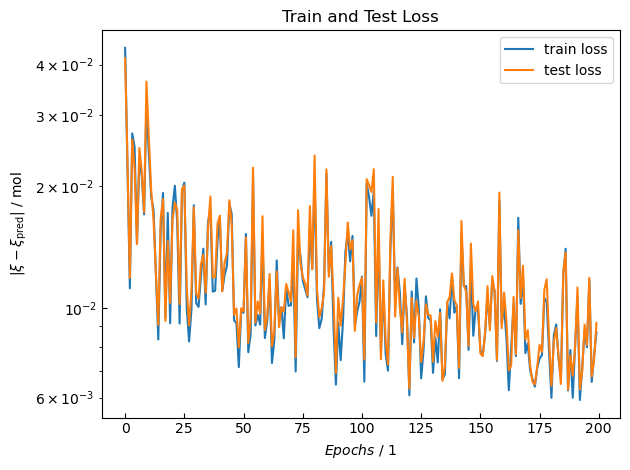

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

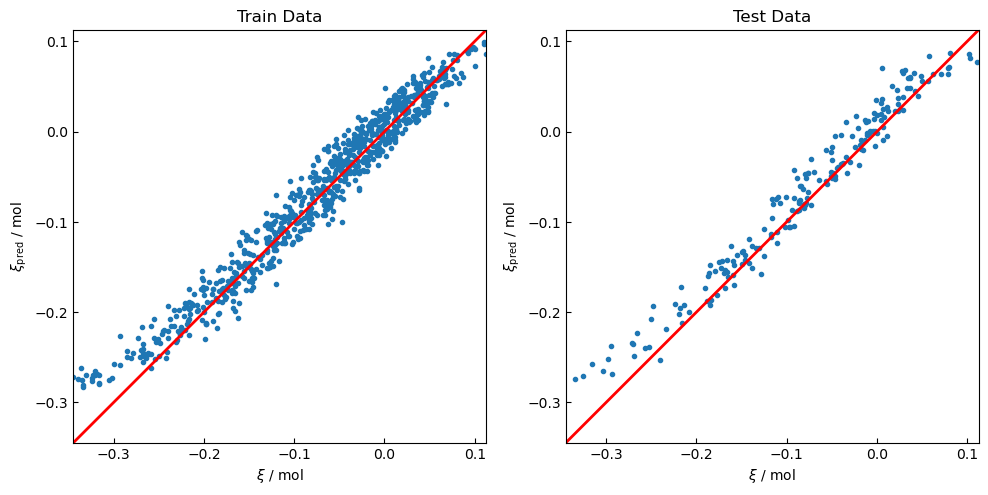

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

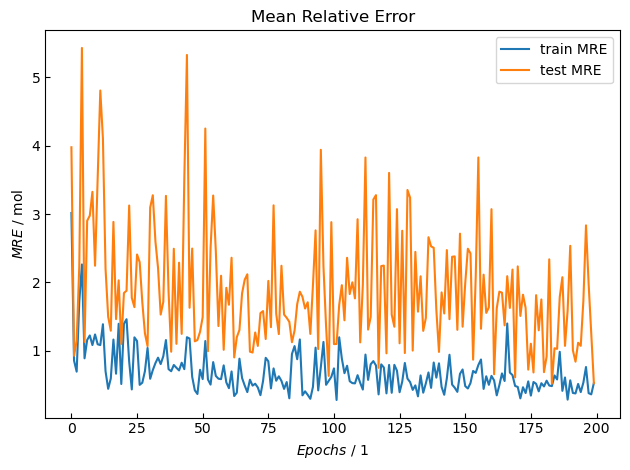

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

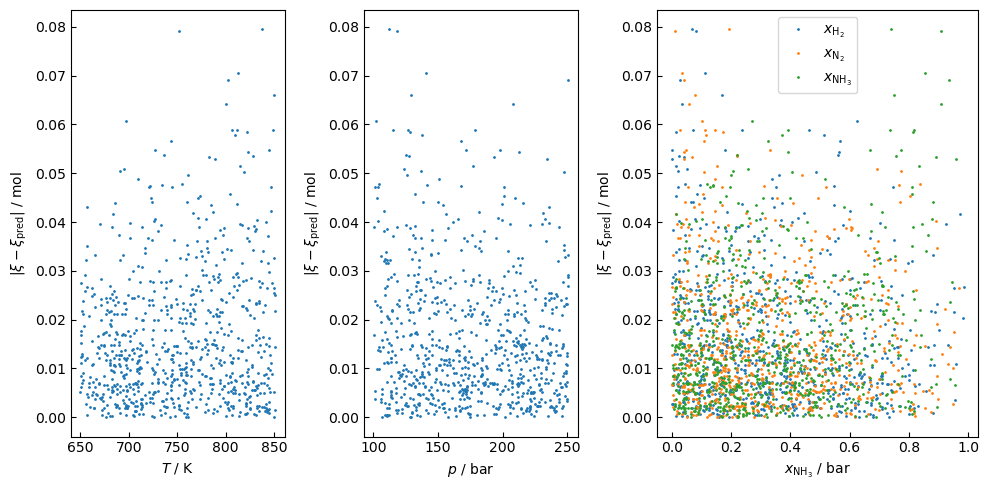

In [12]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

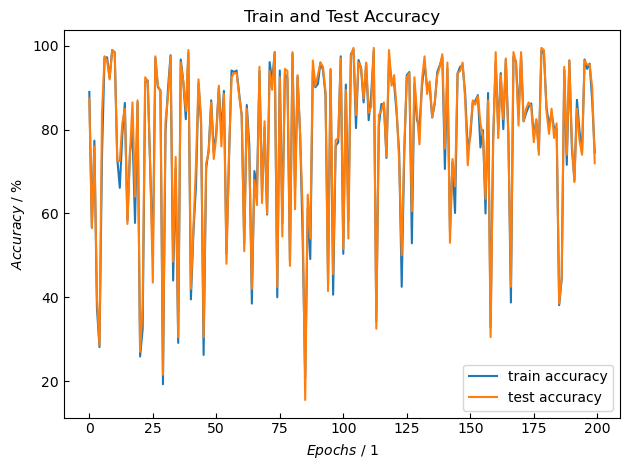

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [14]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[7.4369e+02, 1.5252e+02, 5.2191e-01, 1.7475e-01, 3.0334e-01],
        [8.2536e+02, 2.4577e+02, 2.0508e-01, 7.4219e-01, 5.2735e-02],
        [6.9545e+02, 1.6973e+02, 7.2566e-01, 2.3808e-01, 3.6254e-02],
        [7.6757e+02, 1.5345e+02, 2.1517e-01, 5.4659e-01, 2.3824e-01],
        [7.1006e+02, 1.0148e+02, 7.4424e-01, 1.3041e-01, 1.2535e-01],
        [6.9682e+02, 1.1063e+02, 1.5887e-01, 5.4630e-01, 2.9483e-01],
        [8.0522e+02, 1.7336e+02, 3.1051e-01, 3.2697e-01, 3.6251e-01],
        [6.8953e+02, 1.3088e+02, 4.3899e-02, 9.0287e-02, 8.6581e-01],
        [8.0404e+02, 1.3135e+02, 7.0771e-01, 1.8693e-01, 1.0536e-01],
        [8.2924e+02, 2.4159e+02, 2.5580e-02, 5.1750e-01, 4.5692e-01],
        [6.6491e+02, 1.0471e+02, 4.9134e-01, 2.4092e-01, 2.6774e-01],
        [7.5279e+02, 1.9438e+02, 4.5689e-01, 8.0041e-02, 4.6306e-01],
        [8.4111e+02, 1.6154e+02, 4.0661e-01, 1.3761e-01, 4.5578e-01],
        [7.0784e+02, 1.3045e+02, 2.9918e-01, 6.4218e-01, 5.8633e-02],
        [7.4358e+02,

#### Einblick in Netzwerk

In [15]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.9648, 0.6931, 0.9492, 0.9437, 0.9357], requires_grad=True),
 Parameter containing:
 tensor([-0.0400,  0.0624, -0.0254,  0.0869, -0.0289], requires_grad=True),
 Parameter containing:
 tensor([[-1.0198e-01, -1.2405e-01, -2.4877e-01, -2.6054e-01, -2.8002e-01],
         [-3.6857e-01, -2.3713e-01, -3.7576e-01, -8.7309e-03, -3.2907e-01],
         [ 1.4032e-01,  2.1031e-01, -3.1331e-01, -3.4490e-01, -4.8038e-02],
         [-5.2337e-02,  2.8903e-01,  2.3325e-01, -1.3761e-01, -5.6602e-02],
         [ 3.5839e-03,  3.3465e-02, -6.4233e-02,  3.8563e-01, -3.0329e-01],
         [ 2.8346e-01,  1.6814e-01,  1.6055e-01, -1.6997e-01, -1.7391e-03],
         [-3.4743e-01,  4.1530e-01,  3.5519e-01,  1.8408e-01, -4.3744e-01],
         [ 2.7943e-01, -3.7500e-01, -2.4214e-01, -1.0259e-01, -2.0437e-01],
         [-4.3564e-02, -2.5370e-02,  2.0249e-02, -6.2926e-02, -2.1700e-01],
         [ 1.4008e-01, -3.7211e-01,  3.5896e-02, -3.8827e-02,  1.7092e-01],
         [-2.0075e-01,  

In [16]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.1387, 0.9640, 0.4355, 0.1028, 0.1416],
        [0.8229, 0.1255, 0.6029, 0.7010, 0.8156]])
tensor([[-0.0439],
        [-0.1195]], grad_fn=<AddmmBackward0>)


In [17]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [18]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[6.5084e+02, 2.0695e+02, 9.2257e-02, 3.2531e-02, 8.7521e-01],
        [6.9523e+02, 1.2374e+02, 5.1510e-02, 6.9270e-01, 2.5579e-01],
        [7.8086e+02, 1.8276e+02, 2.5856e-01, 6.9524e-01, 4.6206e-02],
        [8.1668e+02, 2.3041e+02, 1.9560e-01, 5.0106e-01, 3.0334e-01],
        [7.6819e+02, 2.4963e+02, 8.9502e-01, 1.7578e-03, 1.0322e-01],
        [7.3072e+02, 1.4723e+02, 2.4696e-02, 3.8059e-01, 5.9472e-01],
        [7.2481e+02, 2.3280e+02, 3.1315e-01, 9.7435e-02, 5.8941e-01],
        [8.2063e+02, 1.2521e+02, 4.6230e-01, 2.4657e-01, 2.9113e-01],
        [7.0901e+02, 1.1099e+02, 6.0126e-01, 3.6644e-01, 3.2299e-02],
        [8.0539e+02, 1.1069e+02, 6.4937e-01, 1.7997e-01, 1.7066e-01],
        [7.3377e+02, 1.1054e+02, 2.8884e-01, 1.8286e-01, 5.2830e-01],
        [7.1845e+02, 1.1063e+02, 3.9012e-01, 5.9804e-02, 5.5008e-01],
        [8.0282e+02, 2.3309e+02, 2.8912e-01, 5.5051e-02, 6.5583e-01],
        [7.1356e+02, 1.2717e+02, 1.1840e-01, 7.3079e-01, 1.5081e-01],
        [7.0040e+02,